# Grover's Algorithm - AAYUSH GROVER

Before going into **Grover's Search Algorithm**, let's code out the classical counterpart to make a direct comparison. We're going to attempt to search for a value within an **unsorted python list** and find out how fast we can do it.

We're going to be using something known as an oracle. In this case, the oracle is going to go through all of our numbers and return True if it reaches the searched number, and False if not. The idea is that we search through this list until the oracle reaches True and find the amount of times the oracle ran.

In [1]:
unsorted_list = [1, 5, 6, 8, 9, 3, 5, 7, 9, 2, 3, 6, 8]

In [2]:
# check each element of list and look to see if it is a 2
def classical_oracle(input):
    searched_num = 2
    if input == searched_num:
        return True
    else:
        return False

In [3]:
for index, num in enumerate(unsorted_list):
    if classical_oracle(num) == True:
        print("Index of searched number: %i"%index)
        print("Oracle called %i times"%(index+1))

Index of searched number: 9
Oracle called 10 times


<hr>
***The number 2 is in the 9th index. To get this value, our oracle had to be called 10 times. We can see that our oracle has to go through every single element to get to the searched value.***

This means that at most, unsorted searched are done in $O(N)$ and on average, $O(\frac{N}{2})$. We're going to be using Grover's Algorithm to reduce this to $O(\sqrt(N))$
<hr>

Grover's Algorithm is a LOT faster, but also much more complicated. Each element is assigned to a certain combination of qubits. For example, if we have the list [1, 2, 3, 4], 1 is assigned to 00, 2 is assigned to 01, 3 is assigned to 10, and 4 is assigned to 11.

The idea is that we find what we're attempting to look for (let's say 4 in this case), multiply it by -1, and then reflect it across the initial state vector. Geometrically speaking, this is known as amplitude amplification and makes the probability of the return being 11 much higher.
<br><br>
<hr>

## Grover's Algorithm Implementation

The **oracle** in Grover's Algorithm is going to search for the specific qubit combination that we're looking for and multiply it by "-1," another way of saying reflect along the Z-axis. 

Then, we're going to use a **Diffuser function** which amplifies its amplitude significantly.

**We run this oracle and diffuser at most $O(\sqrt(N))$ times to get an accurate result, thus speeding up our search significantly**

In [4]:
from qiskit import *
import matplotlib.pyplot as plt
import numpy as np

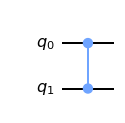

In [5]:
# oracle function
oracle = QuantumCircuit(2, name = 'oracle')
oracle.cz(0,1) # this gate creates a phase flip on |11>, marking it
oracle.to_gate()
oracle.draw(output='mpl')

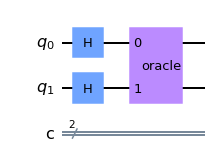

In [6]:
grover_circuit = QuantumCircuit(2,2)
grover_circuit.h([0,1])
grover_circuit.append(oracle, [0,1])
grover_circuit.draw(output='mpl')

In [7]:
backend = Aer.get_backend('statevector_simulator')
result = execute(grover_circuit, backend).result()

In [8]:
statevector = result.get_statevector()
print(np.asarray(statevector))

[ 0.5+0.j  0.5+0.j  0.5+0.j -0.5+0.j]


As we can see, the only state that's multiplied by -1 is the state 11. However, utilizing the Born rule, we still see that the probabilities are $\frac{1}{4}$ to get each of the states. To change this, we need to utilize amplitude amplitifaction through the **diffuser circuit**

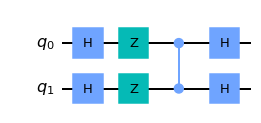

In [9]:
diffuser = QuantumCircuit(2, name = 'diffuser')
diffuser.h([0,1])
diffuser.z([0,1])
diffuser.cz(0,1)
diffuser.h([0,1])
diffuser.to_gate()
diffuser.draw(output='mpl')

In [10]:
backend = Aer.get_backend('qasm_simulator')
grover_circuit = QuantumCircuit(2,2)
grover_circuit.h([0,1])
grover_circuit.append(oracle, [0,1])
grover_circuit.append(diffuser, [0,1])
grover_circuit.measure([0,1], [0,1])

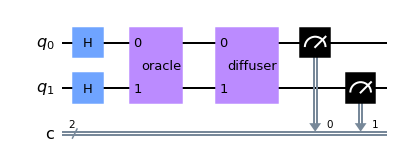

In [11]:
grover_circuit.draw(output='mpl')

In [12]:
result = execute(grover_circuit, backend).result()
result.get_counts()

{'11': 1024}

As we can see, our result is always 11 no matter what! Our algorithm is a success.

## Let's recreate the circuit but this time, let's create a general circuit and use 3 qubits instead of 2

In [13]:
num_of_qubits = 3

In [18]:
# create a circuit initializer
def circ_initializer(qc, qubits):
    for qubit in qubits:
        qc.h(qubit)
    return qc

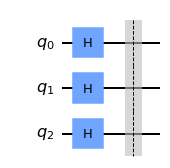

In [19]:
grover_circuit = QuantumCircuit(num_of_qubits)
grover_circuit = circ_initializer(grover_circuit, [0,1,2])
grover_circuit.barrier()
grover_circuit.draw(output='mpl')

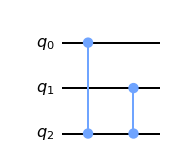

In [16]:
# for this example, let's mark |101> and |110> using to controlled-z gates
oracle = QuantumCircuit(num_of_qubits)
oracle.cz(0, 2)
oracle.cz(1, 2)
oracle.to_gate()
oracle.name = "U$_w$"
oracle.draw(output='mpl')

In [17]:
# general diffuser function
def diffuser(num_of_qubits):
    diffuser = QuantumCircuit(num_of_qubits)
    for qubit in range(num_of_qubits):
        diffuser.h(qubit)
    for qubit in range(num_of_qubits):
        diffuser.x(qubit)
    diffuser.h(num_of_qubits-1)
    diffuser.mct(list(range(num_of_qubits-1)), num_of_qubits-1)  # multi-controlled-toffoli
    diffuser.h(num_of_qubits-1)
    for qubit in range(num_of_qubits):
        diffuser.x(qubit)
    for qubit in range(num_of_qubits):
        diffuser.h(qubit)
    diffuser.to_gate()
    diffuser.name = "U$_s$"
    return diffuser

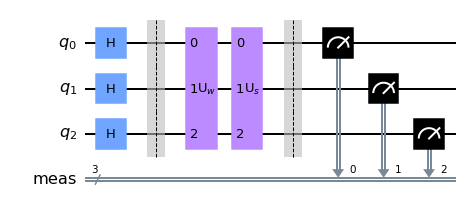

In [20]:
# create finished circuit
grover_circuit = QuantumCircuit(num_of_qubits)
grover_circuit = circ_initializer(grover_circuit, [0,1,2])
grover_circuit.barrier()
grover_circuit.append(oracle, [0,1,2])
grover_circuit.append(diffuser(num_of_qubits), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw(output='mpl')

Now, let's test are algorithm! Our expected result should be around 50% |110> and 50% |101>. Due to the probabilistic  nature of quantum, this won't be 100% accurate but it should be close.

In [22]:
backend = Aer.get_backend('qasm_simulator')
result = execute(grover_circuit, backend).result()
result.get_counts()

{'110': 503, '101': 521}

Perfect! Our Grover's algorithm works on 3 qubits. This can even be scaled up to any amount of qubits - however current quantum computers may not be able to support that due to quantum decoherence and noise.

Let's graph a histogram of our results to conclude Grover's Algorithm!

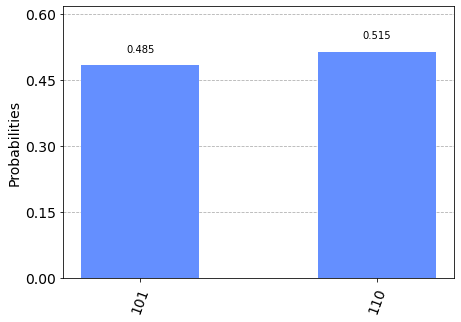

In [24]:
from qiskit.visualization import plot_histogram
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)